# Fresh Start for Ising Model
Thanks to Jake Vanderplas for two amazing YouTube videos on constructing the model and optimizing with Cython 
* <a href=https://youtu.be/rN7g4gzO2sk>Optimization with Cython: Ising Models (Part 1)</a>
* <a href=https://youtu.be/LOzcSuw3yOY>Optimization with Cython: Ising Models (Part 2)</a>

In [1]:
import numpy as np

def random_spin_field(N, M):
    return np.random.choice([-1, 1], size=(N, M))

random_spin_field(10, 10)

array([[ 1,  1, -1, -1,  1, -1,  1, -1, -1, -1],
       [-1, -1, -1,  1, -1, -1,  1, -1, -1, -1],
       [-1, -1,  1,  1, -1, -1,  1, -1,  1, -1],
       [-1, -1,  1,  1,  1,  1, -1,  1,  1,  1],
       [-1, -1, -1,  1, -1,  1,  1,  1,  1,  1],
       [ 1,  1, -1, -1,  1, -1, -1,  1,  1,  1],
       [ 1, -1,  1, -1, -1,  1, -1,  1, -1, -1],
       [ 1, -1,  1,  1, -1,  1, -1, -1,  1,  1],
       [-1,  1, -1,  1,  1, -1,  1,  1, -1,  1],
       [ 1,  1,  1,  1, -1,  1,  1,  1,  1, -1]])

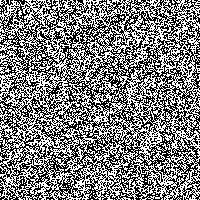

In [2]:
from PIL import Image

def display_spin_field(field):
    return Image.fromarray(np.uint8((field + 1) * 0.5 * 255))

display_spin_field(random_spin_field(200, 200))

In [3]:
def ising_step(field, beta=0.4):
    N, M = field.shape
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _ising_update(field, n, m, beta)
    return field

def _ising_update(field, n, m, beta):
    total = 0
    N, M = field.shape
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    dE = 2 * field[n,m] * total
    if dE <= 0:
        field[n,m] *= -1
    elif np.exp(-dE * beta) > np.random.rand():
        field[n,m] *= -1

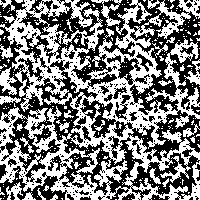

In [4]:
display_spin_field(ising_step(random_spin_field(200, 200)))

## Animate Sequence with ipywidgets

In [5]:
from ipywidgets import interact

def display_ising_sequence(images):
    def _show(frame=(0, len(images)-1)):
        return display_spin_field(images[frame])
    return interact(_show)

The problem here is we've got about 6 nested for loops, which is *atrocious* in Python, so this next cell will be slow even for small pictures with few frames.

In [6]:
images = [random_spin_field(200, 200)]
for i in range(50):
    images.append(ising_step(images[-1].copy()))
display_ising_sequence(images)

interactive(children=(IntSlider(value=25, description='frame', max=50), Output()), _dom_classes=('widget-inter…

<function __main__.display_ising_sequence.<locals>._show(frame=(0, 50))>

# Speed it up with Cython

In [7]:
%load_ext Cython

In [8]:
%%cython -a

cimport cython

import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX


@cython.boundscheck(False)
@cython.wraparound(False)
def cy_ising_step(np.int64_t[:,:] field, float beta=0.4):
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    _cy_ising_update(field, n, m, beta)
    return np.array(field)


@cython.boundscheck(False)
@cython.wraparound(False)
cdef _cy_ising_update(np.int64_t[:,:] field, int n, int m, float beta):
    cdef int total = 0
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int i, j
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    cdef float dE = 2 * field[n,m] * total
    if dE <= 0:
        field[n,m] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        field[n,m] *= -1

In [9]:
field = random_spin_field(200, 200)
%timeit ising_step(field)
%timeit cy_ising_step(field)

495 ms ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.87 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Now that we have a ~200 times speedup, lets try a bigger image!

In [11]:
images = [random_spin_field(500, 500)]
for i in range(100):
    images.append(cy_ising_step(images[-1].copy(), beta=0.3))
display_ising_sequence(images)

interactive(children=(IntSlider(value=50, description='frame'), Output()), _dom_classes=('widget-interact',))

<function __main__.display_ising_sequence.<locals>._show(frame=(0, 100))>